In [1]:
from torchvision import transforms, models, datasets
import os, torch, time, itertools
import collections
from collections import OrderedDict

import numpy as np
import torch.nn as nn

#!pip install scikit-plot
import scikitplot as skplt
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, roc_curve, auc, roc_auc_score


from timm import create_model
data_dir = '/Downloads/Covid/Cough/d/'
batch_size = 256
img_size = 320 #224 for ViT and DeiT
test_size = int((256 / 224) * img_size)
mean = [0.485, 0.456, 0.406] 
std = [0.229, 0.224, 0.225]
num_workers = 8
device = torch.device("cuda")

In [2]:
!ls '/Downloads/Covid/Cough/d/'

test  train  val  weights


In [3]:
# Define your transforms for the training and testing sets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(test_size),
        transforms.CenterCrop(img_size),
        transforms.ColorJitter(0.5, 0.5, 0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]), 
    'val': transforms.Compose([
        transforms.Resize(test_size),
        transforms.CenterCrop(img_size),
        transforms.ColorJitter(0.5, 0.5, 0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]), 
    'test': transforms.Compose([
        transforms.Resize(test_size),
        transforms.CenterCrop(img_size),
        transforms.ColorJitter(0.5, 0.5, 0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

# Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train','val', 'test']}
class_names = image_datasets['test'].classes
num_classes = len(class_names)
data_loader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=num_workers, pin_memory = True)
              for x in ['train','val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val', 'test']}

print(class_names)
print(dataset_sizes)
print(device)

### we get the class_to_index in the data_Set but what we really need is the cat_to_names  so we will create
_ = image_datasets['test'].class_to_idx
cat_to_name = {_[i]: i for i in list(_.keys())}
print(cat_to_name)
    
# Run this to test the data loader
images, labels = next(iter(data_loader['test']))
images.size()

['healthy', 'no_resp_illness_exposed', 'positive_asymp', 'positive_mild', 'positive_moderate', 'recovered_full', 'resp_illness_not_identified']
{'train': 7439, 'val': 927, 'test': 937}
cuda
{0: 'healthy', 1: 'no_resp_illness_exposed', 2: 'positive_asymp', 3: 'positive_mild', 4: 'positive_moderate', 5: 'recovered_full', 6: 'resp_illness_not_identified'}


torch.Size([256, 3, 320, 320])

# Utils

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.suam(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

def plt_roc(test_y, probas_y, plot_micro=False, plot_macro=False):
    assert isinstance(test_y, list) and isinstance(probas_y, list), 'the type of input must be list'
    #ROCAUC(test_y, probas_y, plot_micro=plot_micro,plot_macro=plot_macro)
    #ROCAUC(test_y, probas_y, plot_micro=plot_micro,plot_macro=plot_macro).score(test_y, probas_y)
    #ROCAUC(test_y, probas_y, plot_micro=plot_micro,plot_macro=plot_macro).show()

    skplt.metrics.plot_roc(test_y, probas_y, plot_micro=plot_micro,plot_macro=plot_macro) #, figsize=(10, 8))
    #plt.savefig(add_prefix(args.prefix, 'roc_auc_curve.png'))
    plt.show()
    #plt.close()

def compute_validate_meter(model, val_loader): # best_model_path,
    
    since = time.time()
    model.to(device)
    model.eval()
    pred_y = list()
    test_y = list()
    probas_y = list()
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            data, target = Variable(data), Variable(target)
            output = model(data)
            probas_y.extend(output.data.cpu().numpy().tolist())
            pred_y.extend(output.data.cpu().max(1, keepdim=True)[1].numpy().flatten().tolist())
            test_y.extend(target.data.cpu().numpy().flatten().tolist())
        # compute the confusion matrix
        confusion = confusion_matrix(test_y, pred_y)
        # plot the confusion matrix
        #plot_labels = ['COVID-19', 'healthy', "symptomatic"]
        plot_labels = ['Health', 'no_resp_illness_exposed', 'positive_asymp',
                      'positive_mild', 'positive_moderate', 'recovered_full', 'resp_illness_not_identified']
        plot_confusion_matrix(confusion, plot_labels)
        #plot_confusion_matrix(confusion, classes=val_loader.dataset.classes,title='Confusion matrix')
        # print Recall, Precision, F1-score, Accuracy
        report = classification_report(test_y, pred_y, digits=4)
        print(report)
        plt_roc(test_y, probas_y)
        
    time_elapsed = time.time() - since

    print('Inference completes in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# EfficientNet_B0 

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 9.78 µs
4016515


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.6629    1.0000    0.7973      4932
           1     0.0000    0.0000    0.0000       628
           2     0.0000    0.0000    0.0000       248
           3     0.0000    0.0000    0.0000      1007
           4     0.0000    0.0000    0.0000        97
           5     0.0000    0.0000    0.0000       268
           6     0.0000    0.0000    0.0000       260

    accuracy                         0.6629      7440
   macro avg     0.0947    0.1429    0.1139      7440
weighted avg     0.4394    0.6629    0.5285      7440



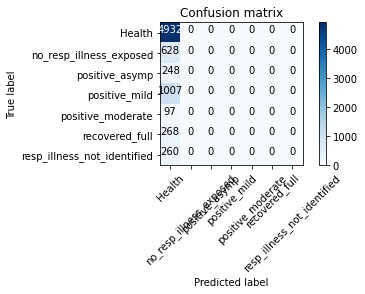

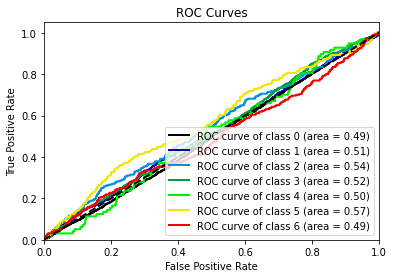

Inference completes in 0m 17s


In [6]:
%time
model = create_model(
        'efficientnet_b0',
        num_classes=7,
        in_chans=3,
        pretrained=True,
        checkpoint_path='/Downloads/Covid/Cough/d/weights/EffNet_B0.pth')

count = count_parameters(model)
print(count)

compute_validate_meter(model, data_loader['train']) 

# ResNet26D

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 7.63 µs
13979751


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.6630    1.0000    0.7973      4932
           1     0.0000    0.0000    0.0000       628
           2     0.0000    0.0000    0.0000       248
           3     0.0000    0.0000    0.0000      1006
           4     0.0000    0.0000    0.0000        97
           5     0.0000    0.0000    0.0000       268
           6     0.0000    0.0000    0.0000       260

    accuracy                         0.6630      7439
   macro avg     0.0947    0.1429    0.1139      7439
weighted avg     0.4396    0.6630    0.5286      7439



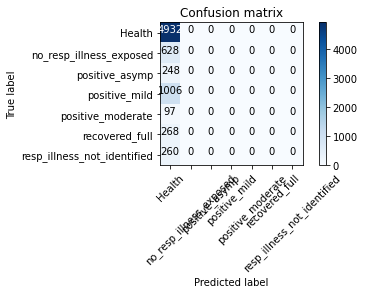

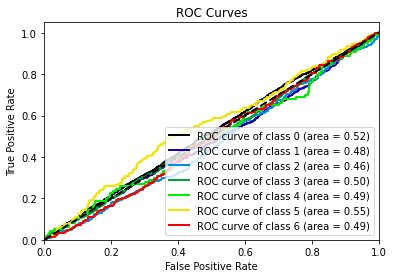

Inference completes in 0m 17s


In [5]:
%time
model = create_model(
        'resnet26d',
        num_classes=7,
        in_chans=3,
        pretrained=True,
        checkpoint_path='/Downloads/Covid/Cough/d/weights/ResNet26D.pth')

count = count_parameters(model)
print(count)

compute_validate_meter(model, data_loader['train']) #best_model_path,

# ResNet50D

CPU times: user 6 µs, sys: 2 µs, total: 8 µs
Wall time: 13.6 µs


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet50d_ra2-464e36ba.pth" to /root/.cache/torch/hub/checkpoints/resnet50d_ra2-464e36ba.pth


23541607
              precision    recall  f1-score   support

           0     0.7182    0.9961    0.8346      4932
           1     0.8896    0.2182    0.3504       628
           2     0.9125    0.2944    0.4451       248
           3     0.8509    0.1927    0.3142      1007
           4     1.0000    0.0412    0.0792        97
           5     0.9302    0.2985    0.4520       268
           6     0.9574    0.1731    0.2932       260

    accuracy                         0.7320      7440
   macro avg     0.8941    0.3163    0.3955      7440
weighted avg     0.7768    0.7320    0.6678      7440



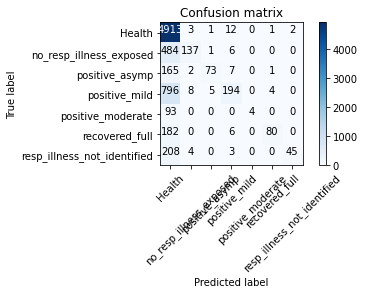

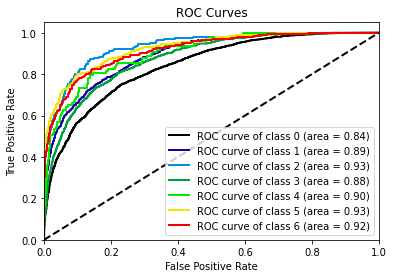

Inference completes in 0m 17s


In [24]:
%time
model = create_model(
        'resnet50d',
        num_classes=7,
        in_chans=3,
        pretrained=True,
        checkpoint_path='/Downloads/Covid/Cough/d/weights/ResNet50D.pth')

count = count_parameters(model)
print(count)

compute_validate_meter(model, data_loader['train']) #best_model_path,

# ECA_NFNet_L0

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.82 µs
21855059
              precision    recall  f1-score   support

           0     0.7642    0.9547    0.8489       618
           1     0.6667    0.4500    0.5373        80
           2     1.0000    0.4375    0.6087        32
           3     0.7143    0.3937    0.5076       127
           4     0.5000    0.0769    0.1333        13
           5     0.8333    0.2941    0.4348        34
           6     0.8462    0.3333    0.4783        33

    accuracy                         0.7599       937
   macro avg     0.7607    0.4200    0.5070       937
weighted avg     0.7589    0.7599    0.7298       937



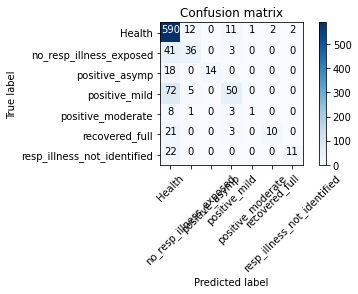

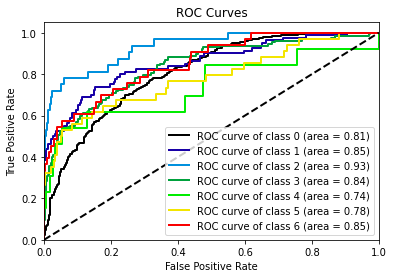

Inference completes in 0m 6s


In [18]:
%time
model = create_model(
        'eca_nfnet_l0',
        num_classes=7,
        in_chans=3,
        pretrained=True,
        checkpoint_path='/Downloads/Covid/Cough/d/weights/ECA_NFNet_L0.pth')

count = count_parameters(model)
print(count)

compute_validate_meter(model, data_loader['test']) #best_model_path,

21855059
              precision    recall  f1-score   support

           0     0.7864    0.9175    0.8469       618
           1     0.6154    0.5000    0.5517        80
           2     0.8750    0.4375    0.5833        32
           3     0.6667    0.4724    0.5530       127
           4     0.3333    0.0769    0.1250        13
           5     0.6316    0.3529    0.4528        34
           6     0.5217    0.3636    0.4286        33

    accuracy                         0.7535       937
   macro avg     0.6329    0.4458    0.5059       937
weighted avg     0.7374    0.7535    0.7338       937



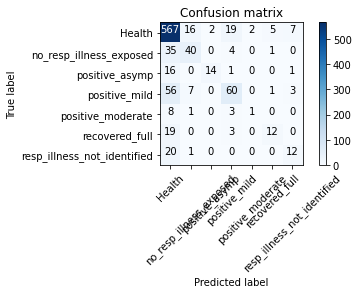

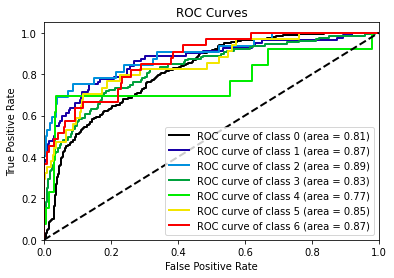

Inference completes in 0m 8s


In [5]:
# %time
model = create_model(
        'eca_nfnet_l0',
        num_classes=7,
        in_chans=3,
        pretrained=True,
        checkpoint_path='/Downloads/Covid/Cough/d/weights/ECA_NFNet_L0_03.pth')

count = count_parameters(model)
print(count)

compute_validate_meter(model, data_loader['test']) #best_model_path,

# ECA_NFNet_320_FineTune

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 7.87 µs
21855059


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.7418    0.9531    0.8343       618
           1     0.7838    0.3625    0.4957        80
           2     0.8462    0.3438    0.4889        32
           3     0.6250    0.3543    0.4523       127
           4     0.0000    0.0000    0.0000        13
           5     0.7273    0.2353    0.3556        34
           6     0.8000    0.2424    0.3721        33

    accuracy                         0.7364       937
   macro avg     0.6463    0.3559    0.4284       937
weighted avg     0.7244    0.7364    0.6966       937



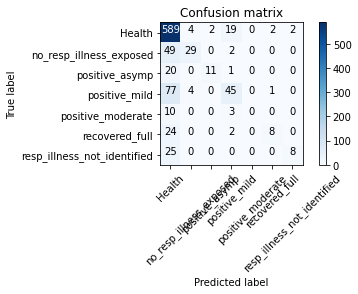

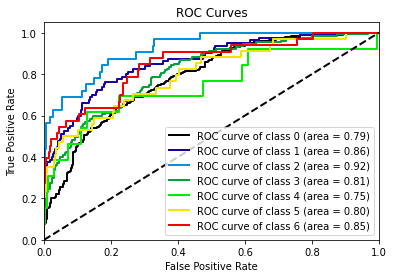

Inference completes in 0m 8s


In [5]:
%time
model = create_model(
        'eca_nfnet_l0',
        num_classes=7,
        in_chans=3,
        pretrained=True,
        checkpoint_path='/Downloads/Covid/Cough/d/weights/averaged.pth')

count = count_parameters(model)
print(count)

compute_validate_meter(model, data_loader['test']) #best_model_path,

# ECA_NFNet_L0_320

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.82 µs
21855059


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.6596    1.0000    0.7949       618
           1     0.0000    0.0000    0.0000        80
           2     0.0000    0.0000    0.0000        32
           3     0.0000    0.0000    0.0000       127
           4     0.0000    0.0000    0.0000        13
           5     0.0000    0.0000    0.0000        34
           6     0.0000    0.0000    0.0000        33

    accuracy                         0.6596       937
   macro avg     0.0942    0.1429    0.1136       937
weighted avg     0.4350    0.6596    0.5242       937



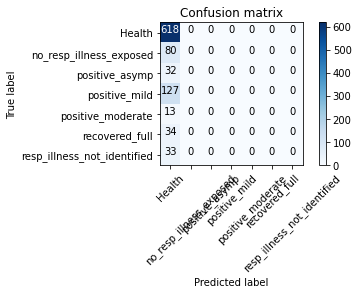

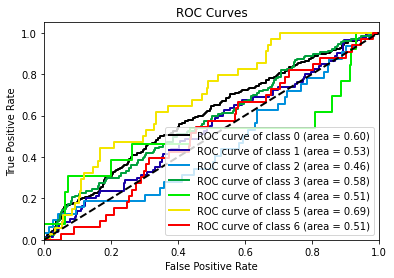

Inference completes in 0m 6s


In [15]:
%time
model = create_model(
        'eca_nfnet_l0',
        num_classes=7,
        in_chans=3,
        pretrained=True,
        checkpoint_path='/Downloads/Covid/Cough/d/weights/ECA_NFNet_L0_320.pth')

count = count_parameters(model)
print(count)

compute_validate_meter(model, data_loader['test']) #best_model_path,

# ECA_NFNet_L0 DROP 0.8

CPU times: user 3 µs, sys: 3 µs, total: 6 µs
Wall time: 11.2 µs
21855059


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.6596    1.0000    0.7949       618
           1     0.0000    0.0000    0.0000        80
           2     0.0000    0.0000    0.0000        32
           3     0.0000    0.0000    0.0000       127
           4     0.0000    0.0000    0.0000        13
           5     0.0000    0.0000    0.0000        34
           6     0.0000    0.0000    0.0000        33

    accuracy                         0.6596       937
   macro avg     0.0942    0.1429    0.1136       937
weighted avg     0.4350    0.6596    0.5242       937



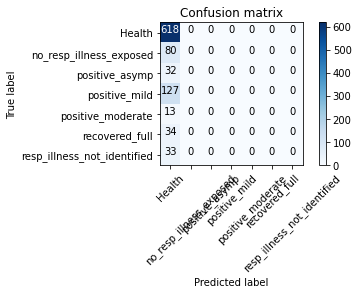

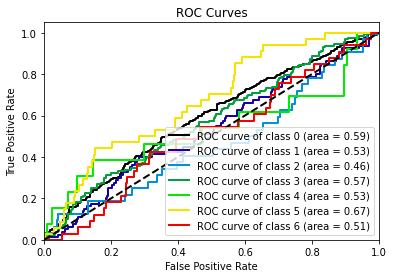

Inference completes in 0m 9s


In [5]:
%time
model = create_model(
        'eca_nfnet_l0',
        num_classes=7,
        in_chans=3,
        pretrained=True,
        checkpoint_path='/Downloads/Covid/Cough/d/weights/ECA_NFNet_L0_08.pth')

count = count_parameters(model)
print(count)

compute_validate_meter(model, data_loader['test']) #best_model_path,

# ECA_NFNet_L1

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.82 µs
38356239


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.6635    0.9996    0.7976      4932
           1     0.0000    0.0000    0.0000       628
           2     0.0000    0.0000    0.0000       248
           3     0.0000    0.0000    0.0000      1007
           4     0.0000    0.0000    0.0000        97
           5     0.8571    0.0224    0.0436       268
           6     0.0000    0.0000    0.0000       260

    accuracy                         0.6634      7440
   macro avg     0.2172    0.1460    0.1202      7440
weighted avg     0.4707    0.6634    0.5303      7440



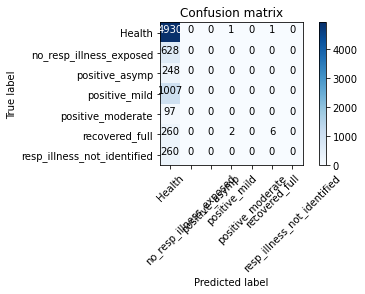

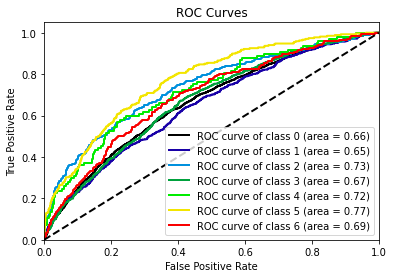

Inference completes in 0m 29s


In [29]:
%time
model = create_model(
        'eca_nfnet_l1',
        num_classes=7,
        in_chans=3,
        pretrained=True,
        checkpoint_path='/Downloads/Covid/Cough/d/weights/ECA_NFNet_L1.pth')

count = count_parameters(model)
print(count)

compute_validate_meter(model, data_loader['train']) #best_model_path,

# DM_NFNet_F0

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 7.87 µs
68437795


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.6633    1.0000    0.7975      4932
           1     1.0000    0.0016    0.0032       628
           2     0.0000    0.0000    0.0000       248
           3     0.0000    0.0000    0.0000      1007
           4     0.0000    0.0000    0.0000        97
           5     1.0000    0.0112    0.0221       268
           6     0.0000    0.0000    0.0000       260

    accuracy                         0.6634      7440
   macro avg     0.3805    0.1447    0.1176      7440
weighted avg     0.5601    0.6634    0.5298      7440



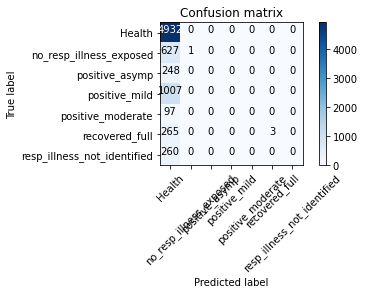

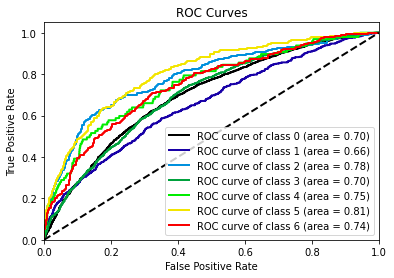

Inference completes in 0m 33s


In [5]:
%time
model = create_model(
        'dm_nfnet_f0',
        num_classes=7,
        in_chans=3,
        pretrained=True,
        checkpoint_path='/Downloads/Covid/Cough/d/weights/DM_NFNet_F0.pth')

count = count_parameters(model)
print(count)

compute_validate_meter(model, data_loader['train']) #best_model_path,

# EfficientNetV2_RW_S

CPU times: user 7 µs, sys: 2 µs, total: 9 µs
Wall time: 14.5 µs
22160847
              precision    recall  f1-score   support

           0     0.8192    0.9592    0.8837      4932
           1     0.8099    0.5494    0.6546       628
           2     0.8342    0.6290    0.7172       248
           3     0.7912    0.5154    0.6242      1007
           4     0.9167    0.5670    0.7006        97
           5     0.9141    0.5560    0.6914       268
           6     0.8555    0.5692    0.6836       260

    accuracy                         0.8203      7440
   macro avg     0.8487    0.6207    0.7079      7440
weighted avg     0.8211    0.8203    0.8074      7440



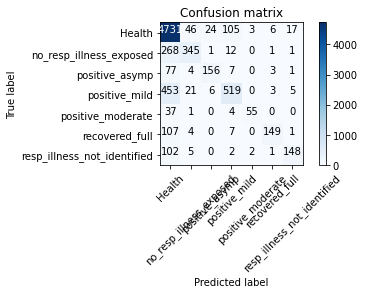

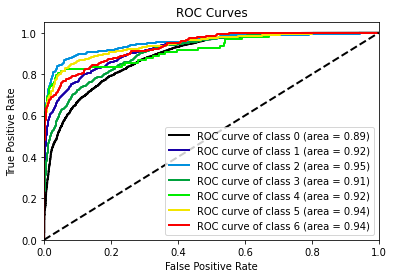

Inference completes in 0m 18s


In [26]:
%time
model = create_model(
        'efficientnetv2_rw_s',
        num_classes=7,
        in_chans=3,
        pretrained=True,
        checkpoint_path='/Downloads/Covid/Cough/d/weights/EffNetV2_RW_S.pth')

count = count_parameters(model)
print(count)

compute_validate_meter(model, data_loader['train']) #best_model_path,

# EffNetV2_RW_M

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs
51098513
              precision    recall  f1-score   support

           0     0.9098    0.9832    0.9450      4932
           1     0.9721    0.7755    0.8627       628
           2     0.9951    0.8185    0.8982       248
           3     0.9121    0.7934    0.8486      1007
           4     0.9070    0.8041    0.8525        97
           5     0.9857    0.7724    0.8661       268
           6     0.9227    0.8269    0.8722       260

    accuracy                         0.9191      7440
   macro avg     0.9435    0.8249    0.8779      7440
weighted avg     0.9213    0.9191    0.9169      7440



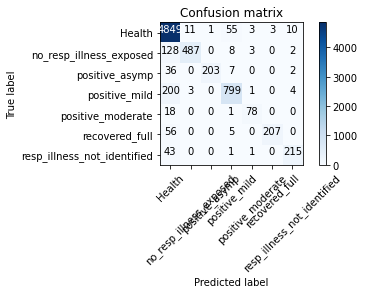

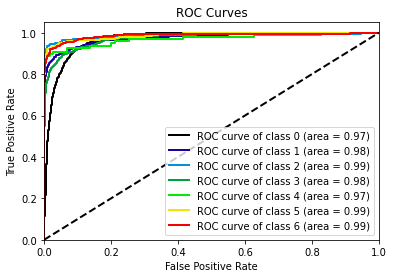

Inference completes in 0m 28s


In [27]:
%time
model = create_model(
        'efficientnetv2_rw_m',
        num_classes=7,
        in_chans=3,
        pretrained=True,
        checkpoint_path='/Downloads/Covid/Cough/d/weights/EffNetV2_RW_M.pth')

count = count_parameters(model)
print(count)

compute_validate_meter(model, data_loader['train']) #best_model_path,

# EffNetV2_B0


In [ ]:
%time
model = create_model(
        'tf_effiencientnetv2_b0',
        num_classes=3,
        in_chans=3,
        pretrained=True,
        checkpoint_path='Covid/Cough/weights/TF_EffNetV2_B0.pth')

count = count_parameters(model)
print(count)

compute_validate_meter(model, data_loader['test']) #best_model_path,